In [1]:
from comet_ml import Experiment
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,StratifiedKFold,KFold,TimeSeriesSplit,GridSearchCV,RepeatedKFold
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,classification_report, PrecisionRecallDisplay,roc_curve, auc
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import os 
import pickle
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt
from comet_api_key import comet_ml_key
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
experiment = Experiment(
    api_key=comet_ml_key(),
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/924942559dc14af995c8755259a7afd4



##### Read Complete NHL DATA

In [3]:
df=pd.read_csv('./tidy_data/complete_dataset.csv',index_col=0)

In [36]:
df

,index,gameID_eventID,period,dateTime,gameID,team,goal,x,y,shooter,...,last_y,game_time,prev_game_time,distance_from_last_event,rebound,speed,sum_x,team_side,distanceNet,shot_angle
0,0,2015030111_55,1,2016-04-15T00:14:04Z,2015030111,Florida Panthers,0,-35.0,31.0,Alex Petrovic,...,-22.0,87,75,55.081757,False,4.590146,-980.0,right,62.265560,29.859016
1,1,2015030111_57,1,2016-04-15T00:15:06Z,2015030111,Florida Panthers,1,-78.0,5.0,Teddy Purcell,...,22.0,115,88,19.235384,False,0.712422,-980.0,right,12.083046,24.443955
2,2,2015030111_59,1,2016-04-15T00:16:00Z,2015030111,Florida Panthers,0,-83.0,-20.0,Nick Bjugstad,...,0.0,126,115,85.375641,False,7.761422,-980.0,right,20.880613,73.300756
3,3,2015030111_61,1,2016-04-15T00:16:48Z,2015030111,New York Islanders,0,48.0,25.0,Thomas Hickey,...,9.0,174,172,29.681644,False,14.840822,663.0,left,48.020829,31.373005
4,4,2015030111_62,1,2016-04-15T00:16:55Z,2015030111,Florida Panthers,0,-57.0,14.0,Aleksander Barkov,...,25.0,179,174,105.574618,True,21.114924,-980.0,right,34.928498,23.629378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467091,467091,2020020868_490,3,2021-05-09T05:02:46Z,2020020868,San Jose Sharks,0,71.0,-16.0,Noah Gregor,...,-33.0,1237,1216,74.953319,False,3.569206,881.0,left,24.083189,41.633539
467092,467092,2020020868_498,4,2021-05-09T05:05:28Z,2020020868,San Jose Sharks,0,-68.0,-14.0,Erik Karlsson,...,0.0,93,60,69.426220,False,2.103825,-68.0,right,25.238859,33.690068
467093,467093,2020020868_500,4,2021-05-09T05:06:21Z,2020020868,Arizona Coyotes,0,56.0,11.0,Conor Garland,...,-22.0,117,94,129.282636,False,5.620984,205.0,left,34.785054,18.434949
467094,467094,2020020868_751,4,2021-05-09T05:07:10Z,2020020868,Arizona Coyotes,0,73.0,6.0,Conor Garland,...,33.0,166,148,106.480045,False,5.915558,205.0,left,17.088007,20.556045


#### Splitting Train Data

In [4]:
train=df[(df['season'] != '20192020') & (df['gameType'] == 'R')]

In [5]:
train.head()

,index,gameID_eventID,game_period,dateTime,gameID,team,goal,x,y,shooter,...,distance_from_last_event,rebound,speed,time_since_powerplay_started,nbFriendly_non_goalie_skaters,nbOpposing_non_goalie_skaters,team_side,distanceNet_or_shotDistance,shot_angle_absolute,change_in_shot_angle
5475,5475,2015020001_8,1,2015-10-07T23:24:23Z,2015020001,Toronto Maple Leafs,0,-55.0,6.0,Brad Boyes,...,154.275727,False,14.025066,0,5,5,right,34.525353,10.007980,0.000000
5476,5476,2015020001_9,1,2015-10-07T23:24:38Z,2015020001,Toronto Maple Leafs,0,-79.0,0.0,Nazem Kadri,...,50.477718,False,7.211103,0,5,5,right,10.000000,0.000000,0.000000
5477,5477,2015020001_16,1,2015-10-07T23:27:21Z,2015020001,Toronto Maple Leafs,0,-75.0,-1.0,Nazem Kadri,...,4.123106,True,4.123106,0,5,5,right,14.035669,4.085617,4.085617
5478,5478,2015020001_10,1,2015-10-07T23:25:24Z,2015020001,Toronto Maple Leafs,0,-55.0,-36.0,Daniel Winnik,...,79.605276,False,4.422515,0,5,5,right,49.517674,46.636577,0.000000
5479,5479,2015020001_14,1,2015-10-07T23:27:08Z,2015020001,Toronto Maple Leafs,0,-61.0,-1.0,Joffrey Lupul,...,22.472205,False,4.494441,0,5,5,right,28.017851,2.045408,0.000000


#### Extracting label class and features from train data

In [6]:
train_x=train[['change_in_shot_angle','shot_angle_absolute','distanceNet_or_shotDistance','nbOpposing_non_goalie_skaters',
'nbFriendly_non_goalie_skaters','time_since_powerplay_started','speed','rebound','distance_from_last_event','x','y','last_x','last_y'
]]
train_y=train['goal']

In [7]:
train_x['rebound'] = train_x['rebound']*1
train_x

,change_in_shot_angle,shot_angle_absolute,distanceNet_or_shotDistance,nbOpposing_non_goalie_skaters,nbFriendly_non_goalie_skaters,time_since_powerplay_started,speed,rebound,distance_from_last_event,x,y,last_x,last_y
5475,0.000000,10.007980,34.525353,5,5,0,14.025066,0,154.275727,-55.0,6.0,94.0,-34.0
5476,0.000000,0.000000,10.000000,5,5,0,7.211103,0,50.477718,-79.0,0.0,-37.0,-28.0
5477,4.085617,4.085617,14.035669,5,5,0,4.123106,1,4.123106,-75.0,-1.0,-79.0,0.0
5478,0.000000,46.636577,49.517674,5,5,0,4.422515,0,79.605276,-55.0,-36.0,-91.0,35.0
5479,0.000000,2.045408,28.017851,5,5,0,4.494441,0,22.472205,-61.0,-1.0,-69.0,-22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409357,164.872821,12.264774,23.537205,5,5,0,3.652250,1,135.133268,66.0,5.0,-69.0,-1.0
409358,0.000000,6.009006,19.104973,5,5,0,NaN,0,NaN,70.0,2.0,NaN,NaN
409359,0.000000,2.385944,24.020824,5,5,0,NaN,0,129.015503,65.0,1.0,-64.0,3.0
409360,0.000000,7.125016,24.186773,5,5,0,NaN,0,130.015384,-65.0,3.0,65.0,1.0


In [8]:
train_y

5475      0
5476      0
5477      0
5478      0
5479      0
         ..
409357    0
409358    0
409359    0
409360    1
409361    0
Name: goal, Length: 380323, dtype: int64

#### Splitting Complete Train dataset into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_x.fillna(0),train_y, test_size=0.25,random_state=10, shuffle = True, stratify=train_y.to_numpy())

{'web': 'https://www.comet.com/api/image/download?imageId=866ac3e44417418292de5746d4908a1c&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=866ac3e44417418292de5746d4908a1c&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': '866ac3e44417418292de5746d4908a1c'}

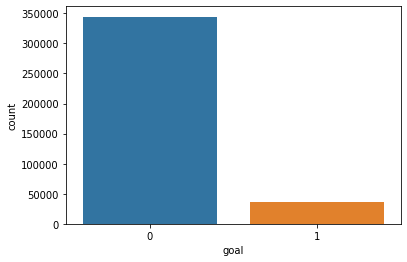

In [10]:
sn.countplot(x ='goal', data = train)
experiment.log_figure(figure_name='Class Label Count Plot', step=None)

In [11]:
for dataset in [X_train, X_val, y_train, y_val]:
    experiment.log_dataset_hash(dataset)

#### Pipeline Function 

In [12]:
def createpipeline(classifier,feature_selection,encoder):

    enc = {
        'Label': OrdinalEncoder(categories='categories‘auto',handle_unknown='use_encoded_value', unknown_value=-1),
        'OneHot': OneHotEncoder(handle_unknown='ignore')
    }
    numeric_encoding = Pipeline([('Impt', SimpleImputer(strategy='mean')),('scaler', StandardScaler()),]) #Scaling of numerical col.
    categorical_encoding = Pipeline([('Impt', SimpleImputer(strategy='most_frequent')),('encoder', enc[encoder]),])  #Encoding of categorical col.
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("Numerical_transform", numeric_encoding, make_column_selector(dtype_include="number")),
            ("Categorical_transform", categorical_encoding, make_column_selector(dtype_exclude="number")),
        ])  
    return Pipeline(steps=[('preprocessor', preprocessor)] + [('feature_select', feature_selection)] + [('classifier', classifier)])

#### Creating Pipeline

In [13]:
classifer= KNeighborsClassifier(n_neighbors='n_neighbors',p=2)
feature_selection=RFE( n_features_to_select='n_features_to_select', verbose =3,estimator=DecisionTreeClassifier())
ecoder='OneHot'
pipe = createpipeline(classifer,feature_selection,ecoder)

In [14]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600AA3BE0>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600AA3C10>)])),
                ('feature_select',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select='n_features_to_select', verbose=3)),
                ('classifier',
                 KNeighborsClassifier(n_neighbors='n_neighbors'))])

#### Searching for best hyperparameters

In [15]:
parameter_space = {'classifier__n_neighbors': [3,5,7],
               'feature_select__n_features_to_select': [1,3,5,7,None],
               
}
# Search for best hyperparamters
cv_strategy = RepeatedKFold(n_splits=3, n_repeats=2) # Cross-validation Method
search = GridSearchCV(pipe, parameter_space, n_jobs=-1, cv=cv_strategy, scoring='f1_macro').fit(X_train, y_train) #Hyperparamerter Search

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.


#### Displaying best Hyperparamters for model

In [16]:
print('BEST PARAMS:', search.best_params_)

BEST PARAMS: {'classifier__n_neighbors': 3, 'feature_select__n_features_to_select': None}


#### Selecting best Estimator and fitting the model

In [17]:
pipe = search.best_estimator_

In [18]:
pipe.fit(X_train,y_train)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600AE4C10>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600AE48E0>)])),
                ('feature_select',
                 RFE(estimator=DecisionTreeClassifier(), verbose=3)),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

#### Testing Model on validation set

In [19]:
y_pred_val = pipe.predict(X_val) 
predictions=pipe.predict_proba(X_val)

In [20]:
print(accuracy_score(y_val, y_pred_val))

0.8841303730503466


#### Quantitative Metrics

In [21]:
report = classification_report(y_val, y_pred_val, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
0,0.910049,0.967703,0.937991,86106.00000
1,0.209943,0.082340,0.118287,8975.00000
accuracy,0.884130,0.884130,0.884130,0.88413
macro avg,0.559996,0.525021,0.528139,95081.00000
weighted avg,0.843964,0.884130,0.860616,95081.00000


{'web': 'https://www.comet.com/api/image/download?imageId=6f75f295adae4832a7f8d01ae6022dbc&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6f75f295adae4832a7f8d01ae6022dbc&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': '6f75f295adae4832a7f8d01ae6022dbc'}

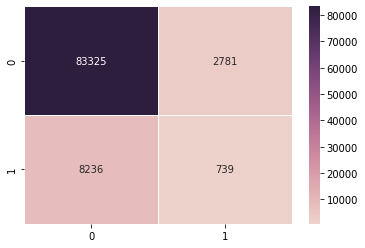

In [22]:
cf_matrix=confusion_matrix(y_val, y_pred_val)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True),linewidth=.5)
experiment.log_figure(figure_name='Confusion Matrix', step=None)

In [23]:
with experiment.test():
    y_pred_ = pipe.predict(X_val)
    metrics = {'accuracy' : pipe.score(X_val,y_val)}
    experiment.log_metrics(metrics)
    experiment.log_confusion_matrix(y_val.to_numpy() , y_pred_)

#### Compute metrics

In [24]:

f1_scr = f1_score(y_val, y_pred_val)
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
metrics = {"accuracy": accuracy, "f1": f1_scr, "recall": recall, "precision": precision}
parameter = {
    "model_type": 'Neural Network',
    "param_grid": str(pipe.get_params()),
}
experiment.log_parameters(parameter)
experiment.log_metrics(metrics)

COMET WARNING: truncated string; too long: '{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600AE4C10>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600AE48E0>)])), ('feature_select', RFE(estimator=DecisionTreeClassifier(), verbose=3)), ('classifier', K

{'web': 'https://www.comet.com/api/image/download?imageId=1df123b7ec1b4be3833f725adcb032b0&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1df123b7ec1b4be3833f725adcb032b0&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': '1df123b7ec1b4be3833f725adcb032b0'}

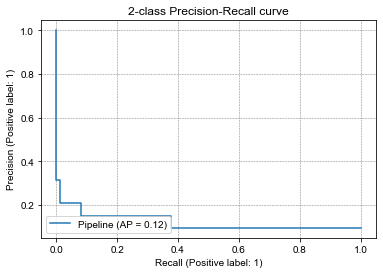

In [25]:
display = PrecisionRecallDisplay.from_estimator(
    pipe, X_val, y_val
)
sn.set()
display.ax_.set_title("2-class Precision-Recall curve")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
experiment.log_figure(figure_name='Precision-Recall Curve', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=503385d87b204f15b9209b90f28e5a64&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=503385d87b204f15b9209b90f28e5a64&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': '503385d87b204f15b9209b90f28e5a64'}

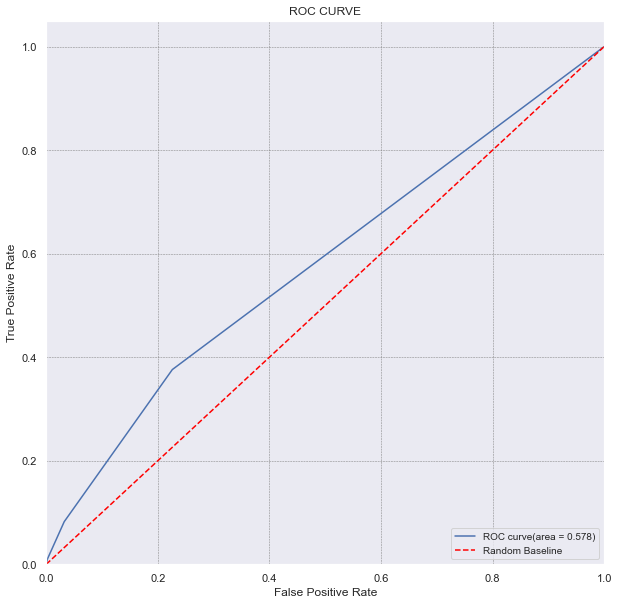

In [26]:
fig = plt.figure(figsize=(10, 10))
# Get FPR, TPR and AUC
fpr, tpr, _ = roc_curve(y_val,predictions[:,1].ravel())
roc_auc = auc(fpr, tpr)
sn.set()
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')
experiment.log_figure(figure_name='ROC-AUC', step=None)

In [27]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
print(bins)
print(bin_centers)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5]


In [28]:
df_prob = pd.DataFrame(list(zip(y_pred_val ,y_val,predictions[:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
df_prob['shot'] = 1
sum_goal = df_prob['goal'].sum()
df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'web': 'https://www.comet.com/api/image/download?imageId=7006e5e0c27b479bbb165492e003ac19&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7006e5e0c27b479bbb165492e003ac19&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': '7006e5e0c27b479bbb165492e003ac19'}

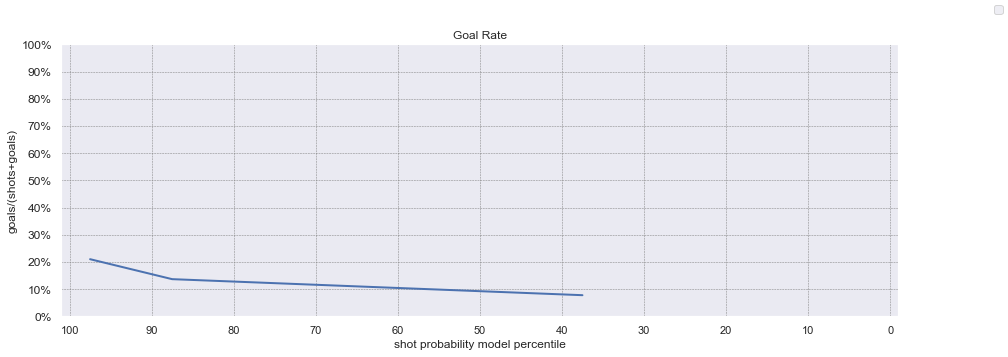

In [29]:
fig = plt.figure(figsize = (15,5))
plt.title(f"Goal Rate")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined, linewidth = 2)
fig.legend(loc="upper right")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('shot probability model percentile')
plt.ylabel('goals/(shots+goals)')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.yticks(np.arange(0,1.1,.1))
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
plt.xticks(np.arange(0,110,10))
experiment.log_figure(figure_name='Goal Rate', step=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'web': 'https://www.comet.com/api/image/download?imageId=c1eed83782974e5db7dc161183de1885&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c1eed83782974e5db7dc161183de1885&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': 'c1eed83782974e5db7dc161183de1885'}

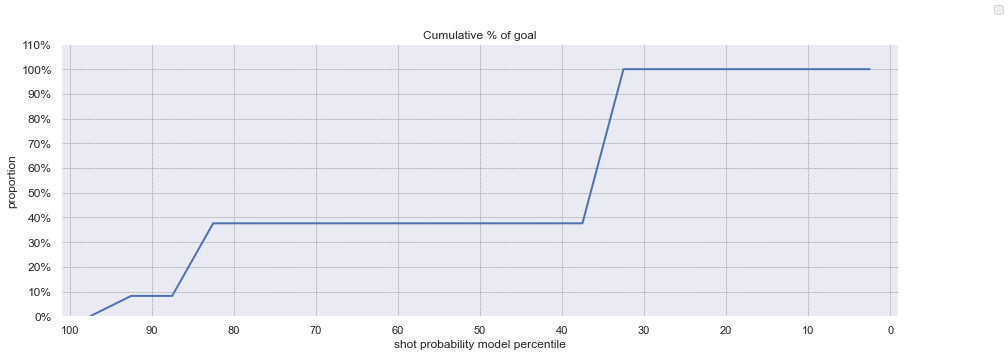

In [30]:
fig = plt.figure(figsize = (15,5))
plt.title(f"Cumulative % of goal")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined, legend = False, linewidth = 2)
fig.legend(loc="upper right")
plt.grid(color='gray', linestyle='--', linewidth=.5)
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.yticks(np.arange(0,1.2,.1))
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)
plt.xticks(np.arange(0,110,10))

experiment.log_figure(figure_name=f'Cumulative % of goals', step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=351418941bbc42e9be4af3a0251eebf6&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=351418941bbc42e9be4af3a0251eebf6&experimentKey=924942559dc14af995c8755259a7afd4',
 'imageId': '351418941bbc42e9be4af3a0251eebf6'}

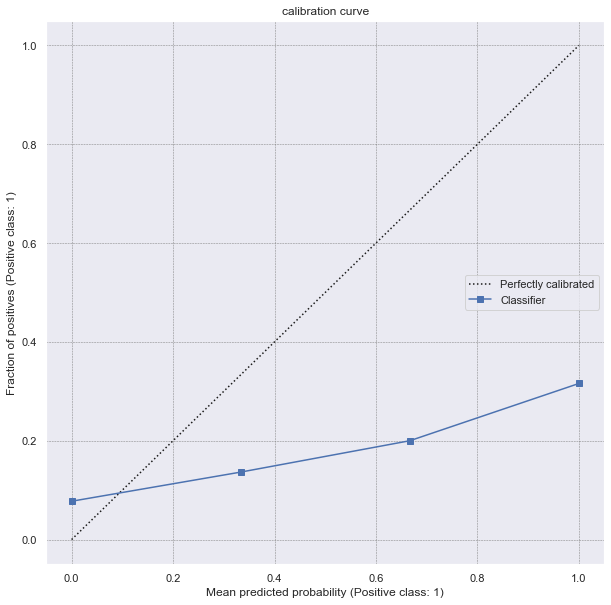

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

disp = CalibrationDisplay.from_predictions(y_val, predictions[:,1].ravel(), n_bins=10, ax=ax)
plt.grid(color='gray', linestyle='--', linewidth=.5)
plt.legend(loc="center right")
plt.title(f"calibration curve")
experiment.log_figure(figure_name='Calibration plots', step=None)

In [32]:
# Saving Model
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(pipe, open('models/Knn.sav', 'wb'))
experiment.log_model("Knn Classifier", 'models/Knn.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=be192f695490441daf767ef444b8a3c1&experimentKey=924942559dc14af995c8755259a7afd4',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=be192f695490441daf767ef444b8a3c1&experimentKey=924942559dc14af995c8755259a7afd4',
 'assetId': 'be192f695490441daf767ef444b8a3c1'}

In [33]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-22-team2/nhl-analytics/924942559dc14af995c8755259a7afd4
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.8841303730503466
COMET INFO:     f1            : 0.11828731492597037
COMET INFO:     precision     : 0.2099431818181818
COMET INFO:     recall        : 0.08233983286908078
COMET INFO:     test_accuracy : 0.8841303730503466
COMET INFO:   Parameters:
COMET INFO:     add_indicator                                                           : False
COMET INFO:     algorithm                                                               : auto
COMET INFO:     ccp_alpha                                                               : 0.0
COMET INFO:     class_weight                                                            : 1
COMET INF